# Estimate the depreciation, MSRP, and Excise Taxes

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textlog import textSetup
text = textSetup(prefix='Depreciation: ')
from warnings import warn

def weighted_percentile (vals, percentiles, weights):
    if len(vals) != len(weights):
        raise ArgumentError('values and weights arrays are not same length!')

    nas = pd.isnull(vals) | pd.isnull(weights)

    nnas = np.sum(nas)
    if nnas > 0:
        warn(f'found {nnas} NAs in data, dropping them')

    vals = vals[~nas]
    weights = weights[~nas]

    weights = weights / np.sum(weights)
    sortIdx = np.argsort(vals)
    vals = vals.iloc[sortIdx]
    weights = weights.iloc[sortIdx]

    cumWeights = np.cumsum(weights)
    if not isinstance(percentiles, np.ndarray):
        percentiles = np.array(percentiles)
    percentiles = percentiles / 100

    # center weights, i.e. put the point value halfway through the weight
    # https://github.com/nudomarinero/wquantiles/blob/master/wquantiles.py
    centeredCumWeights = cumWeights - 0.5 * weights
    return np.interp(percentiles, centeredCumWeights, vals)


In [2]:
vehicles = pd.read_csv('../data/vehicles_insurance.csv')
vehicles = vehicles[vehicles.kind != 'Something Else']

In [3]:
np.sum(vehicles.VEHYEAR < 1997) / len(vehicles)

0.08861610620484942

## Estimate depreciation tables from the NHTS

We compute the median value for each age of vehicle and use it to calculate depreciation tables.

In [4]:
vehicles['depreciationType'] = vehicles.kind.replace({ 'Other Truck': 'Truck', 'Pickup': 'Truck' }).astype('category')
vehicles['age'] = 2017 - vehicles.VEHYEAR
vehicles['depage'] = (vehicles.age + 1) // 2

def getDepreciationSeries (typ):
    return typ.groupby('depage').apply(lambda x: weighted_percentile(x.value, 50, x.WTHHFIN))

# use non-imputed value
# get the years right, each is two years, except for 0
medianCost = vehicles[~pd.isnull(vehicles.value)].groupby('depreciationType').apply(getDepreciationSeries)\
    .rename(columns=lambda x: x * 2 - 0.5).rename(columns={-0.5: 0})
for i in range(1, 20): # add back in integer years
    medianCost[i] = np.nan
    
medianCost = medianCost.transpose().sort_index()

for col in medianCost.columns:
    medianCost[col] = medianCost[col].interpolate('values')
    
medianCost.drop(index=[x for x in medianCost.index if x % 1 != 0 or x > 15], inplace=True)

depreciation = medianCost.apply(lambda x: x / medianCost.loc[0], 1)
depreciation = depreciation.stack().reset_index().rename(columns={0: 'depreciationValueProportion', 'depage': 'age'})
vehicles.drop(columns=['depage'], inplace=True)

medianCost

depreciationType,Car,SUV,Truck,Van
depage,,,,
0.0,23479.309683,27563.233150,40947.263658,42527.558882
1.0,19812.760879,24945.797771,37511.051436,31685.634844
2.0,16956.881278,22484.151851,33883.285701,24475.382354
3.0,14911.670881,20178.295391,30063.966453,20896.801413
4.0,13164.299261,17980.298470,27053.044311,18324.355542
5.0,11714.766420,15890.161088,24850.519273,16758.044741
6.0,10406.770778,14100.634533,22608.559487,14576.768003
7.0,9240.312334,12611.718804,20327.164953,11780.525327
8.0,8228.256641,11234.845710,18371.498656,9806.377905


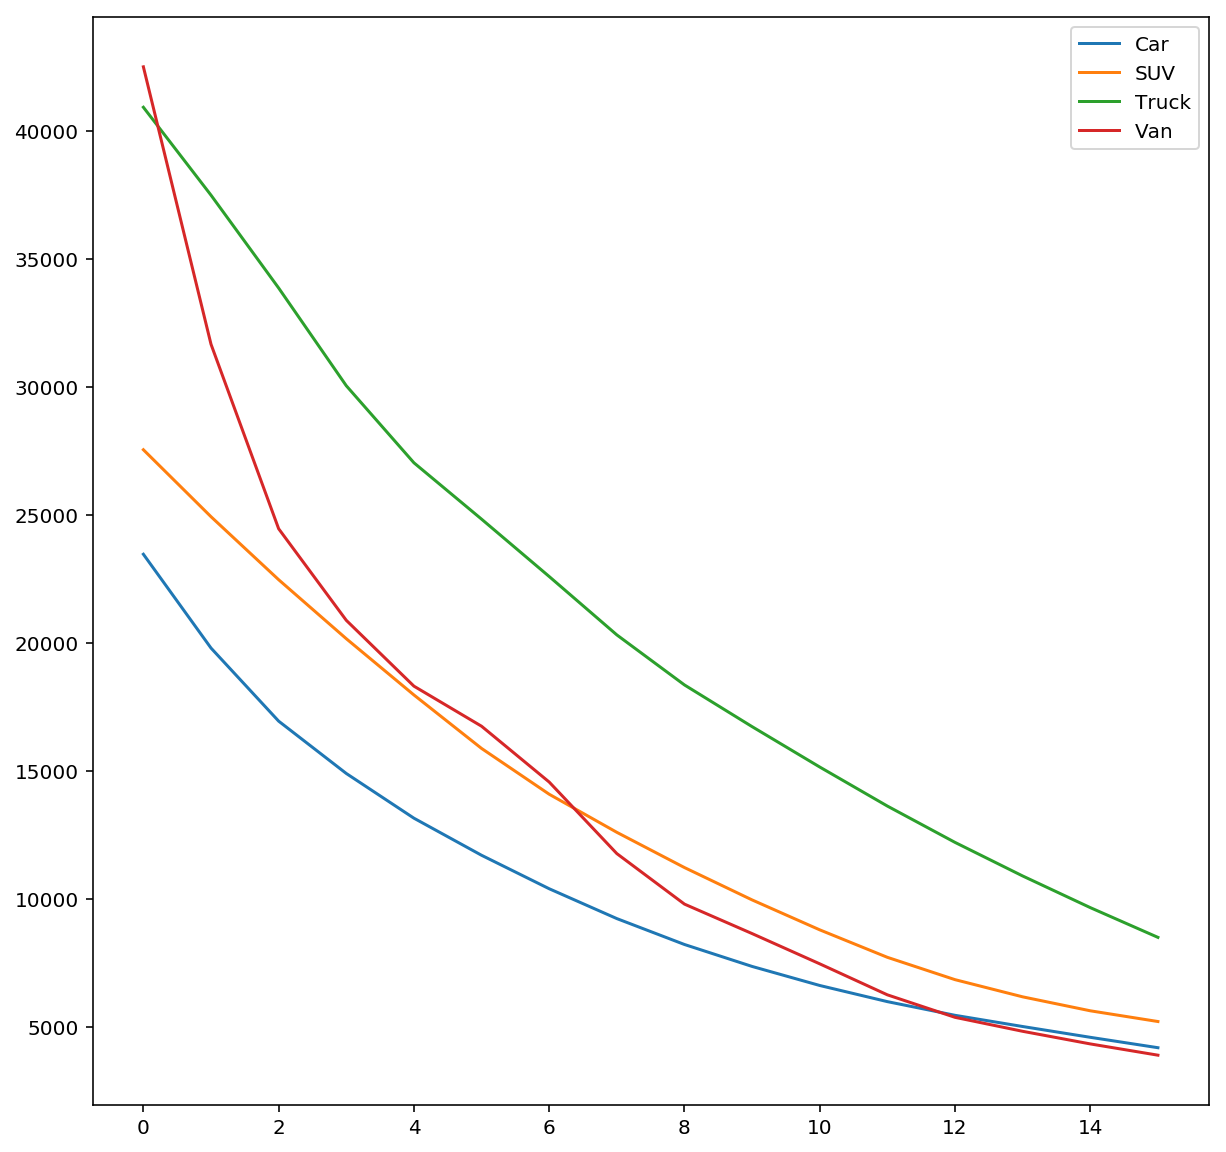

In [5]:
plt.figure(figsize=(10, 10))
for kind in medianCost.columns:
    plt.plot(medianCost.index, medianCost[kind], label=kind)

plt.legend()

In [6]:
vehiclesWithDepreciation = vehicles.copy()
vehiclesWithDepreciation['nextYearDepreciationAge'] = vehiclesWithDepreciation.age + 1
vehiclesWithDepreciation = vehiclesWithDepreciation.merge(
    depreciation,
    on=['age', 'depreciationType'],
    how='left',
    validate='m:1'
)

vehiclesWithDepreciation = vehiclesWithDepreciation.merge(
    depreciation.rename(columns={'depreciationValueProportion': 'nextYearDepreciationValueProportion'}),
    left_on=['nextYearDepreciationAge', 'depreciationType'],
    right_on=['age', 'depreciationType'],
    how='left',
    validate='m:1'
)

# recompute age, some nans were generated above by old vehicles
vehiclesWithDepreciation['age'] = 2017 - vehiclesWithDepreciation.VEHYEAR
    
vehiclesWithDepreciation['nextYearValue'] =\
    vehiclesWithDepreciation.nextYearDepreciationValueProportion / vehiclesWithDepreciation.depreciationValueProportion *\
    vehiclesWithDepreciation.value_imputed
vehiclesWithDepreciation['msrp'] = (1 / vehiclesWithDepreciation.depreciationValueProportion *\
    vehiclesWithDepreciation.value_imputed).fillna(0)
vehiclesWithDepreciation['annualDepreciation'] =\
    (vehiclesWithDepreciation.value_imputed - vehiclesWithDepreciation.nextYearValue).fillna(0)


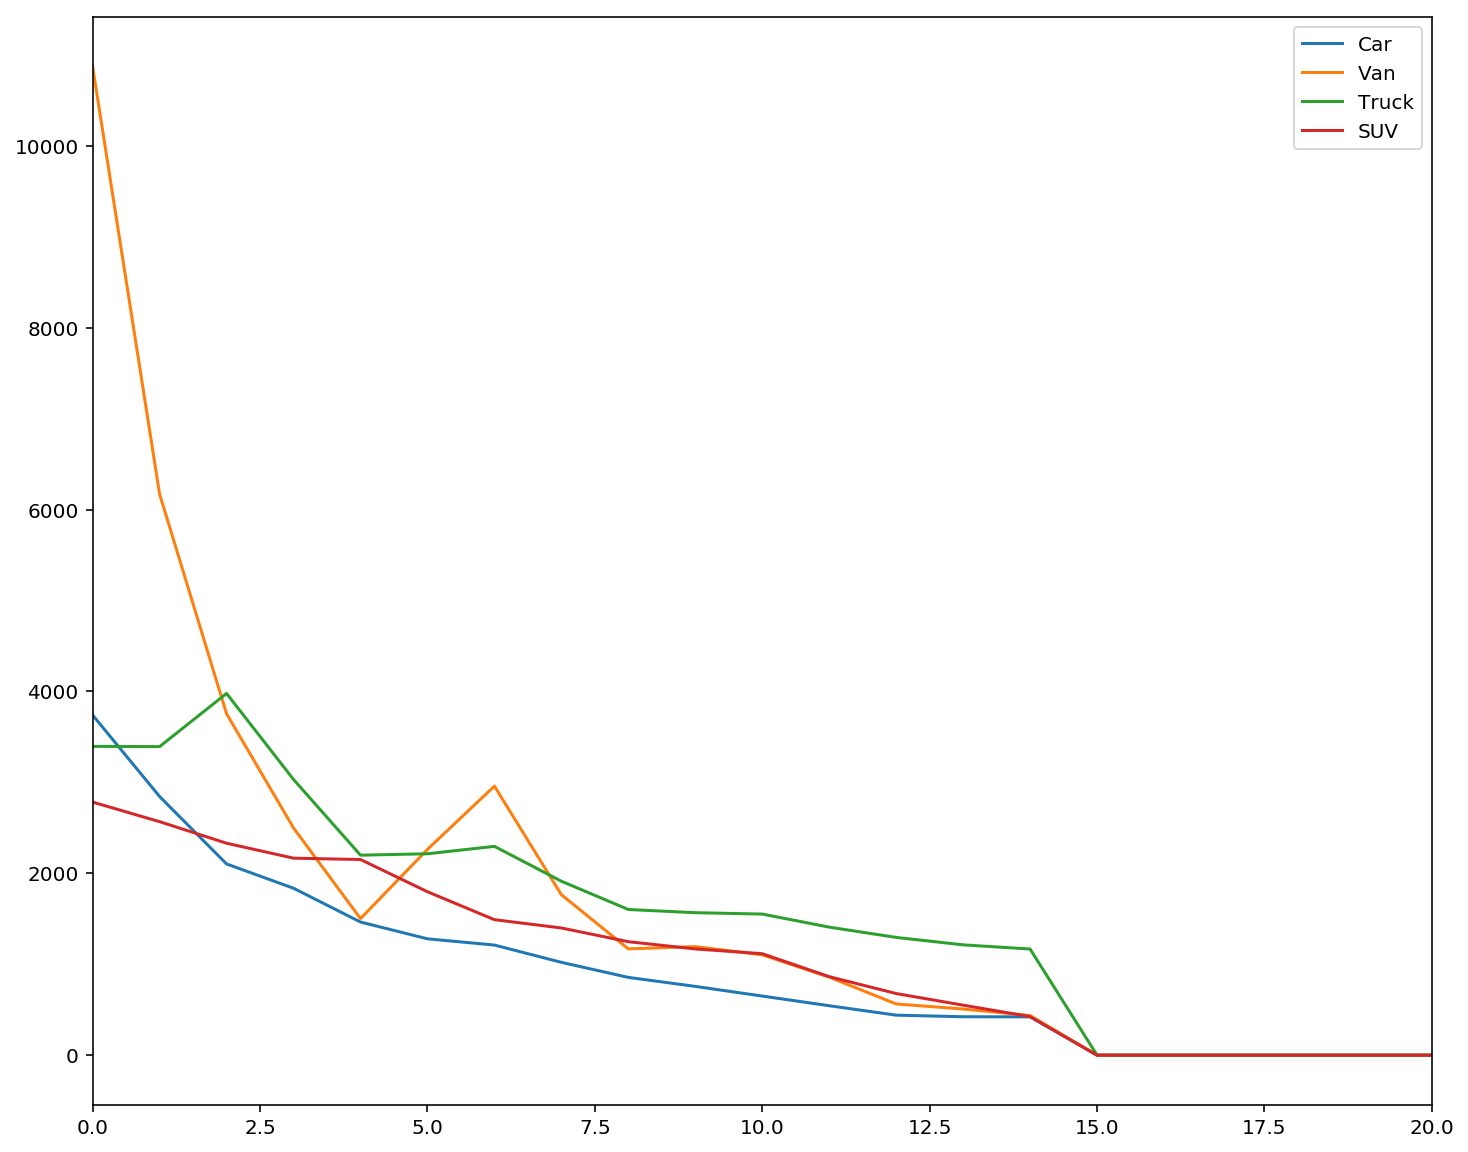

In [14]:
plt.figure(figsize=(12, 10))
for kind in ['Car', 'Van', 'Truck', 'SUV']:
    medianDepreciation = vehiclesWithDepreciation[vehiclesWithDepreciation.depreciationType == kind]\
        .groupby('age').annualDepreciation.apply(lambda x: weighted_percentile(x, 50, vehiclesWithDepreciation.WTHHFIN.loc[x.index]))
    plt.plot(medianDepreciation.index, medianDepreciation, label=kind)
    plt.xlim(0, 20)
    
plt.legend()

## Compute Indiana excise taxes

In [8]:
indianaTaxTable = pd.read_excel('IN reg fees.xlsx', skiprows=1)
indianaTaxTable

,lo_price,hi_price,0,1,2,3,4,5,6,7,8,9
0,0,1499,12,12,12,12,12,12,12,12,12,12
1,1500,2249,36,30,27,24,18,12,12,12,12,12
2,2250,2999,50,50,42,33,24,18,12,12,12,12
3,3000,3999,50,50,50,50,48,36,24,18,12,12
4,4000,5499,66,57,50,50,50,50,42,24,12,12
5,5500,6999,84,74,63,52,50,50,49,30,18,12
6,7000,8499,103,92,77,64,52,50,50,40,21,12
7,8500,9999,123,110,93,78,64,50,50,50,34,12
8,10000,12499,150,134,115,98,82,65,52,50,40,12
9,12500,14999,172,149,130,112,96,79,65,53,50,12


In [9]:
def computeIndianaExciseTaxes (vehicle):
    # find the row
    row = indianaTaxTable[(indianaTaxTable.lo_price <= vehicle.value_imputed) & (indianaTaxTable.hi_price + 1 > vehicle.value_imputed)].iloc[0]
    return row.loc[min(int(vehicle.age), 9)]
    
vehiclesWithDepreciation['in_value_fee'] = 0
indiana = vehiclesWithDepreciation.HHSTATE == 'IN'
vehiclesWithDepreciation.loc[indiana, 'in_value_fee'] = vehiclesWithDepreciation[indiana]\
    .apply(computeIndianaExciseTaxes, 1)

In [10]:
np.sum(pd.isnull(vehiclesWithDepreciation.VEHYEAR))

0

In [11]:
vehiclesWithDepreciation.to_csv('../data/vehicles_depreciation.csv')

In [12]:
vehiclesWithDepreciation.drop(columns='modelName').to_stata('../data/vehicles_depreciation.dta')

/Users/matthewc/anaconda/envs/py37/lib/python3.7/site-packages/pandas/io/stata.py:2138: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    b'Unnamed: 0'   ->   Unnamed__0
    b'Unnamed: 0.1'   ->   Unnamed__0_1
    b'Unnamed: 0.1.1'   ->   Unnamed__0_1_1
    b'Unnamed: 0.1.1.1'   ->   Unnamed__0_1_1_1
    b'nextYearDepreciationValueProportion'   ->   nextYearDepreciationValueProport

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  warnings.warn(ws, InvalidColumnName)
